In [55]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing


--- DATA COLLECTION AND DATA LOADING ---

In [56]:
# Loading the dataset

avocado_data = pd.read_csv("avocado_dataset.csv", encoding='latin1')
print(avocado_data.head())

   Unnamed: 0        Date  AveragePrice  Total Volume  PLU 4046  PLU 4225   \
0           0  27-12-2015          1.33      64236.62   1036.74   54454.85   
1           1  20-12-2015          1.35      54876.98    674.28   44638.81   
2           2  13-12-2015          0.93     118220.22    794.70  109149.67   
3           3  06-12-2015          1.08      78992.15   1132.00   71976.41   
4           4  29-11-2015          1.28      51039.60    941.48   43838.39   

   PLU 4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0     48.16     8696.87     8603.62       93.25          0.0  conventional   
1     58.33     9505.56     9408.07       97.49          0.0  conventional   
2    130.50     8145.35     8042.21      103.14          0.0  conventional   
3     72.58     5811.16     5677.40      133.76          0.0  conventional   
4     75.78     6183.95     5986.26      197.69          0.0  conventional   

   year  region  
0  2015  Albany  
1  2015  Albany  
2  2015 

In [57]:
# Information about the dataset
print(avocado_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   PLU 4046      18249 non-null  float64
 5   PLU 4225      18249 non-null  float64
 6   PLU 4770      18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB
None


Observation:

The dataset is loaded but has encoding issues. This was resolved by enconding "latin1" to handle it. The head and inf has given an understanding of the dataset that it has 18249 entries and 14 columns. There are no null values in this and the datatypes of the dataset are int64, float64 and object.

--- DATA PREPROCESSING ---

In [58]:
# Drop the irrelevant column
avocado_data_cleaned = avocado_data.drop(columns=['Unnamed: 0'])

avocado_data_cleaned['Date'] = pd.to_datetime(avocado_data_cleaned['Date'], format='%d-%m-%Y')

# Renaming columns with trailing spaces for futher analysis
avocado_data_cleaned.columns = avocado_data_cleaned.columns.str.strip()

avocado_data_cleaned.head()



,Date,AveragePrice,Total Volume,PLU 4046,PLU 4225,PLU 4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [59]:
# Information of cleaned dataset
avocado_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   PLU 4046      18249 non-null  float64       
 4   PLU 4225      18249 non-null  float64       
 5   PLU 4770      18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.8+ MB


Observations:

Dropped the irrelevant column and converted the date column to datetime. Removed the spaces between column names. Now the cleaned dataset contains 13 columns where date column datatype is datetime64[ns].

In [60]:
# Data Characteristics
print(avocado_data_cleaned.describe())

                                Date  AveragePrice  Total Volume  \
count                          18249  18249.000000  1.824900e+04   
mean   2016-08-13 23:30:43.498273792      1.405978  8.506440e+05   
min              2015-01-04 00:00:00      0.440000  8.456000e+01   
25%              2015-10-25 00:00:00      1.100000  1.083858e+04   
50%              2016-08-14 00:00:00      1.370000  1.073768e+05   
75%              2017-06-04 00:00:00      1.660000  4.329623e+05   
max              2018-03-25 00:00:00      3.250000  6.250565e+07   
std                              NaN      0.402677  3.453545e+06   

           PLU 4046      PLU 4225      PLU 4770    Total Bags    Small Bags  \
count  1.824900e+04  1.824900e+04  1.824900e+04  1.824900e+04  1.824900e+04   
mean   2.930084e+05  2.951546e+05  2.283974e+04  2.396392e+05  1.821947e+05   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    8.540700e+02  3.008780e+03  0.000000e+00  5.088640e+03  2.849420

In [61]:
# Check for missing values
missing_values = avocado_data_cleaned.isnull().sum()
print(missing_values)

Date            0
AveragePrice    0
Total Volume    0
PLU 4046        0
PLU 4225        0
PLU 4770        0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64


In [62]:
# Checking for number of duplicate rows

duplicates_count = avocado_data_cleaned.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

print(avocado_data_cleaned.shape)

Number of duplicate rows: 0
(18249, 13)


In [63]:
# Outlier Detection

def check_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Checking for outliers for numerical columns only
numerical_columns = ['AveragePrice', 'Total Volume', 'PLU 4046', 'PLU 4225','PLU 4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']

outlier_summary = {}
for column in numerical_columns:
    outliers = check_outliers(avocado_data_cleaned, column)
    outlier_summary[column] = len(outliers)

outlier_summary


{'AveragePrice': 209,
 'Total Volume': 2297,
 'PLU 4046': 2518,
 'PLU 4225': 2519,
 'PLU 4770': 2918,
 'Total Bags': 2533,
 'Small Bags': 2407,
 'Large Bags': 2707,
 'XLarge Bags': 4014}

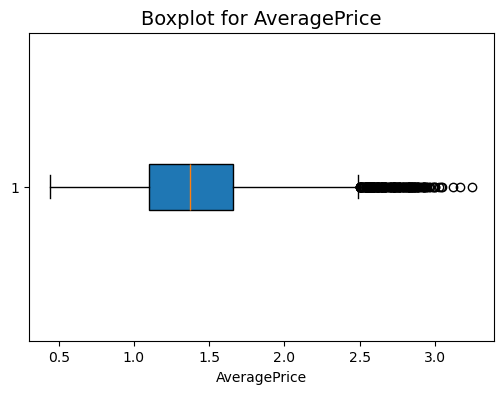

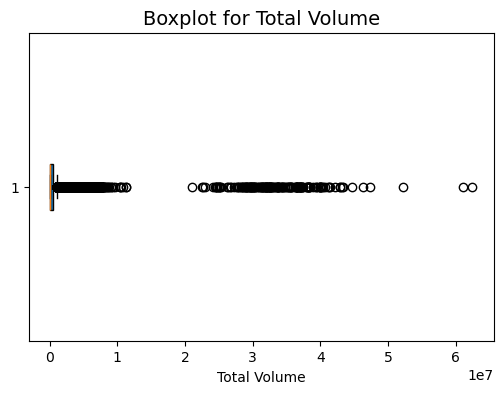

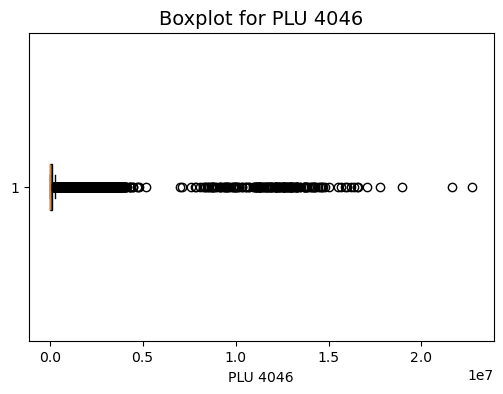

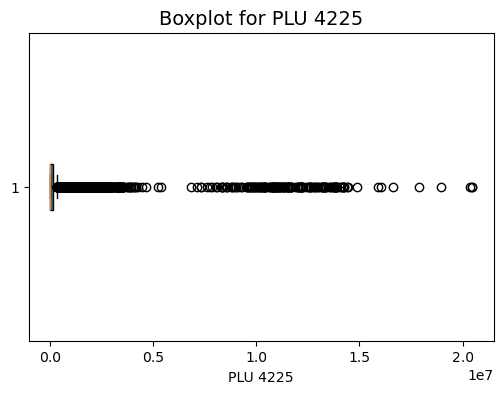

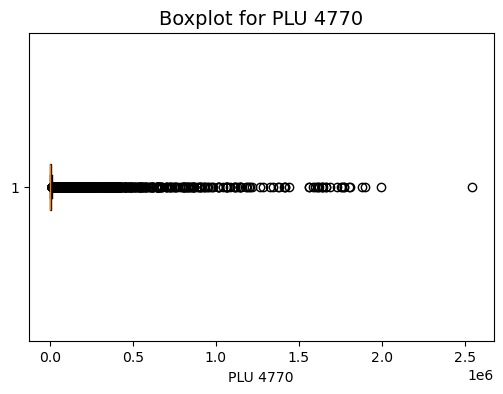

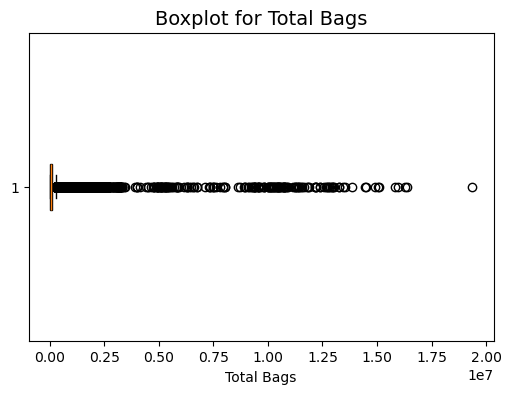

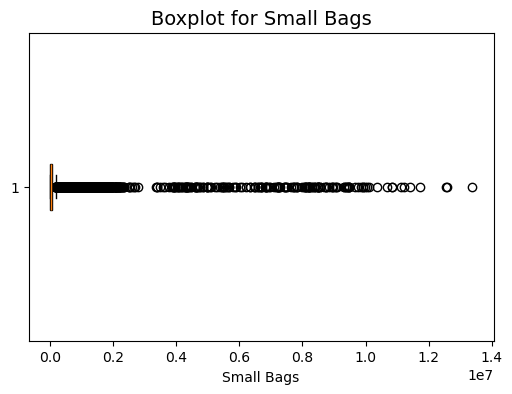

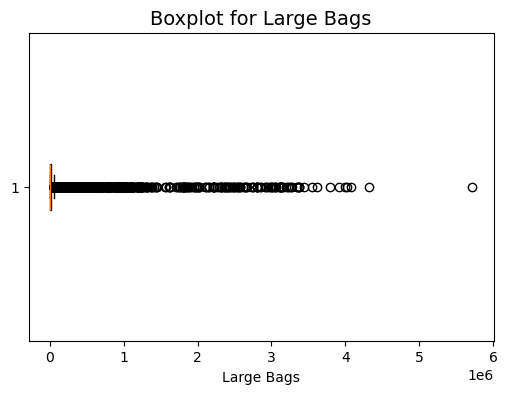

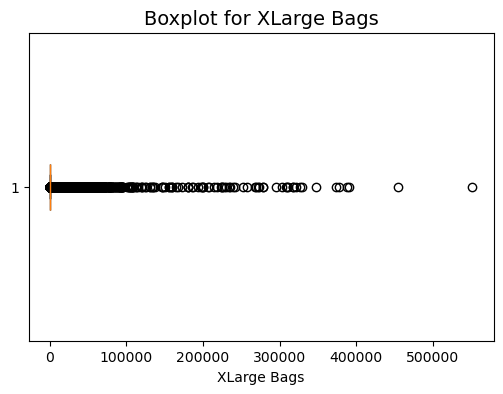

In [64]:
# Boxplot for outliers

for column in numerical_columns:
    plt.figure(figsize=(6, 4))
    plt.boxplot(avocado_data_cleaned[column], vert=False, patch_artist=True)
    plt.title(f"Boxplot for {column}", fontsize=14)
    plt.xlabel(column)
    plt.show()


In [65]:
# Remove outliers

def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

avocado_data_cleaned_1 = avocado_data_cleaned.copy()
columns_to_clean = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'PLU 4046', 'PLU 4225', 'PLU 4770']

for column in numerical_columns:
    avocado_data_cleaned_1 = remove_outliers(avocado_data_cleaned_1, column)

print("Original dataset shape:", avocado_data_cleaned.shape),
print("After removing outliers shape:", avocado_data_cleaned_1.shape)

Original dataset shape: (18249, 13)
After removing outliers shape: (6725, 13)


Observation: 

The dataset has no missing values and no duplicate values so no further handling is required for it. I have checked for outliers in the dataset only for numerical columns using IQR method and there many outliers found in all numerical columns, the count is more in avocado sales and pricing. These outliers are mapped using box plot for visualization. The outliers were handled using IQR method and the size of the dataset has reduced from 18249 entries to 6725 entries. Now the data after outlier removal is less skewed for analysis and we can proceed further.

In [66]:
# Data Segmentation

# Aggregate the data by weekly frequency
avocado_weekly_data = (avocado_data_cleaned_1.set_index('Date').resample('W').agg({'AveragePrice': 'mean', 'Total Volume': 'sum', 
            'PLU 4046': 'sum', 'PLU 4225': 'sum', 'PLU 4770': 'sum', 'Total Bags': 'sum', 'Small Bags': 'sum', 'Large Bags': 'sum', 
            'XLarge Bags': 'sum'}).reset_index())

print(avocado_weekly_data.shape)
print(avocado_weekly_data.head())


(169, 10)
        Date  AveragePrice  Total Volume   PLU 4046   PLU 4225  PLU 4770  \
0 2015-01-04      1.584038     895969.75  361085.98  320183.12   4031.79   
1 2015-01-11      1.625385     848452.30  362390.68  324917.23   3490.89   
2 2015-01-18      1.664800     783900.24  294814.92  334007.28   3705.50   
3 2015-01-25      1.674615     747352.28  269268.13  297667.80   3913.53   
4 2015-02-01      1.530638     827711.27  358259.10  306885.70   3721.20   

   Total Bags  Small Bags  Large Bags  XLarge Bags  
0   210668.86   192113.44    18555.42          0.0  
1   157653.50   137668.95    19984.55          0.0  
2   151372.54   135672.67    15699.87          0.0  
3   176502.82   154307.93    22194.89          0.0  
4   158845.27   145358.69    13486.58          0.0  


Observation: 

We have applied weekly segmentation as it gives sufficient values for further analysis. Monthly and yearly would result in lesser values which would not help in getting the correct result. Weekly segmentation of data has given us 169 rows considering the respective numerical columns. Column values are weekly averages for Average Price and sum for Total Volume. 

--- EXPLORATORY DATA ANALYSIS ---

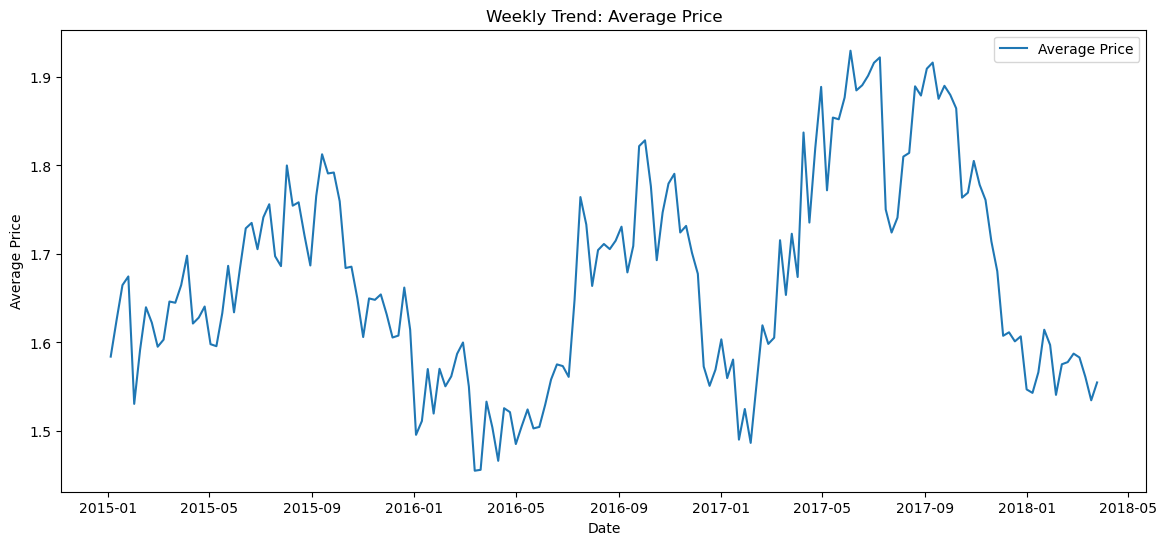

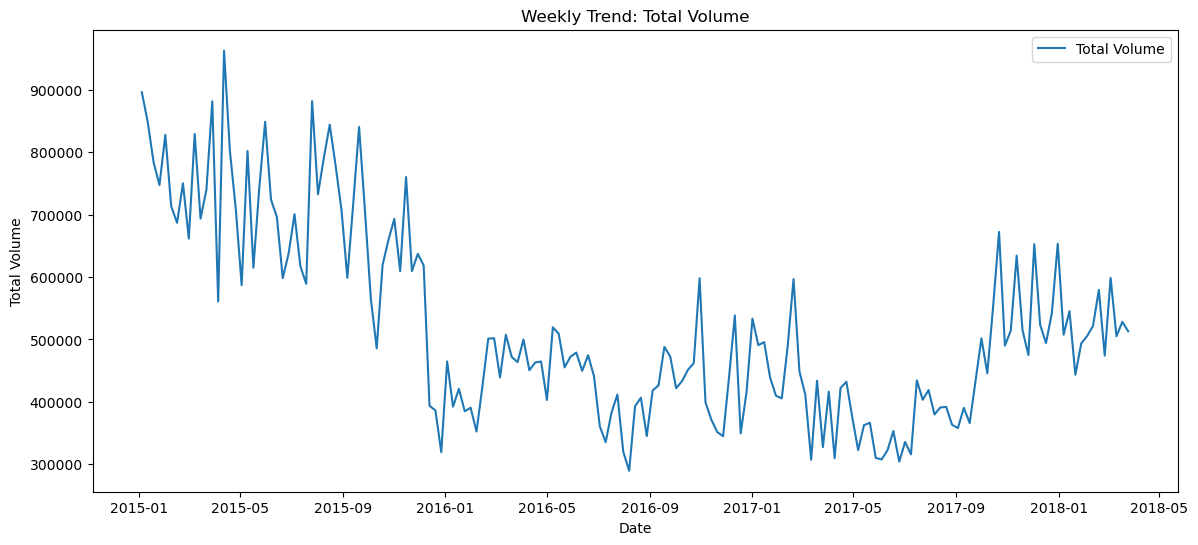

In [67]:
# Visualize weekly trends for AveragePrice
plt.figure(figsize=(14, 6))
plt.plot(avocado_weekly_data['Date'], avocado_weekly_data['AveragePrice'], label='Average Price')
plt.title('Weekly Trend: Average Price',)
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend()
plt.show()

# Visualize weekly trends for Total Volume
plt.figure(figsize=(14, 6))
plt.plot(avocado_weekly_data['Date'], avocado_weekly_data['Total Volume'], label='Total Volume')
plt.title('Weekly Trend: Total Volume')
plt.xlabel('Date')
plt.ylabel('Total Volume')
plt.legend()
plt.show()


Observation:

The average price of avocados has gone up and down over the years reaching its highest point in mid year of 2017 before starting to drop. The total number of avocados sold was much higher in 2015 but it has dropped after that and then slowly it picked up again towards the end of 2017. This could reflect changes in demand, supply or market trends.

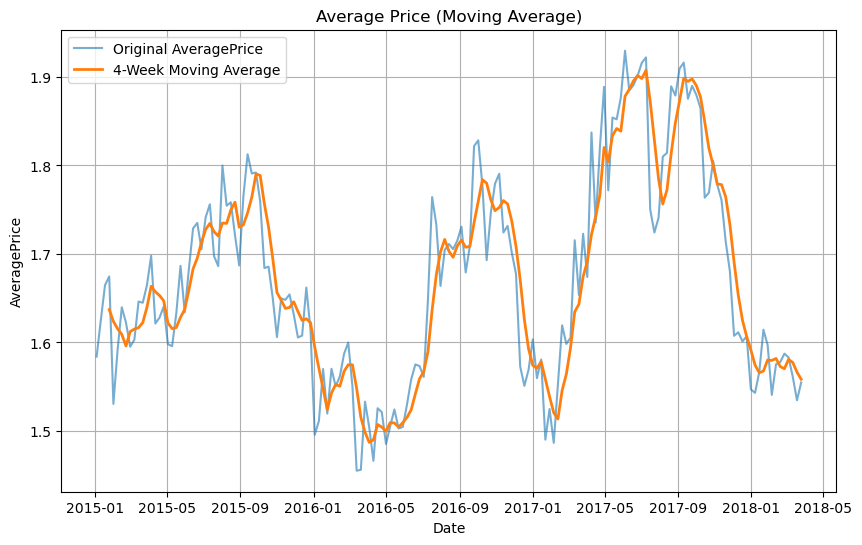

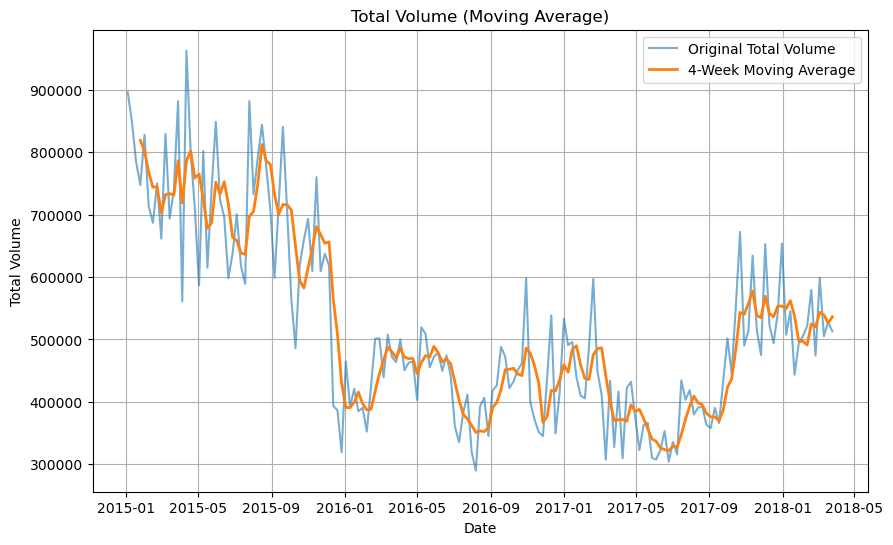

In [68]:
# Moving Averages Plot for Average Price and Total Volume
def plot_moving_averages(data, column, window, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data['Date'], data[column], label=f'Original {column}', alpha=0.6)
    plt.plot(data['Date'], data[column].rolling(window=window).mean(), label=f'{window}-Week Moving Average', linewidth=2)
    plt.title(f'{title} (Moving Average)')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_moving_averages(avocado_weekly_data, 'AveragePrice', window=4, title='Average Price')
plot_moving_averages(avocado_weekly_data, 'Total Volume', window=4, title='Total Volume')

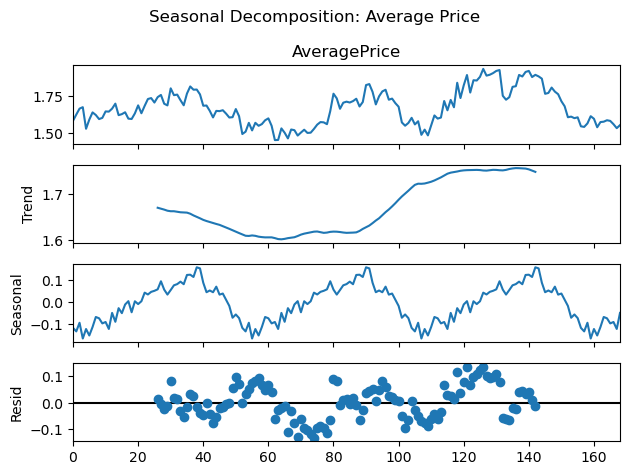

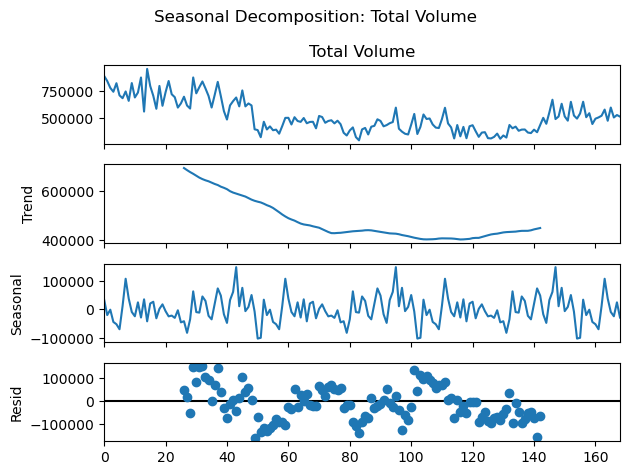

In [69]:
# Seasonal Decomposition

def seasonal_decomposition(data, column, period, title):
    decomposition = seasonal_decompose(data[column], model='additive', period=period)
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition: {title}')
    plt.tight_layout()
    plt.show()

# Seasonal decomposition for Average Price and Total Volume
seasonal_decomposition(avocado_weekly_data, 'AveragePrice', period=52, title='Average Price')
seasonal_decomposition(avocado_weekly_data, 'Total Volume', period=52, title='Total Volume')


Observation:

The seasonal decomposition breaks down the data into its trend, seasonal and residual components. For the average price, it shows a clear upward trend peaking in 2017 along with seasonal fluctuations. For the total volume the trend shows a decline and then there was slight upwards but the seasonal pattern indicates periodic variations in sales volume. This helps to understand long-term trends and recurring patterns in the data.

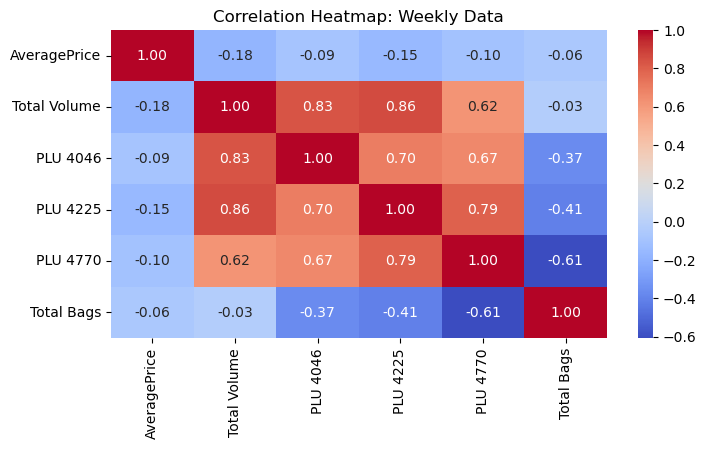

In [70]:
# Correlation Heatmap

correlation_matrix = avocado_weekly_data[['AveragePrice', 'Total Volume', 'PLU 4046', 'PLU 4225', 'PLU 4770', 'Total Bags']].corr()

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Weekly Data")
plt.show()


Observation:

The heatmap shows how different factors are related to each other. Total volume is strongly related to specific avocado types (PLU 4046, PLU 4225, PLU 4770) which means higher sales for these types increase total volume. The average price has a weak or negative relationship with most factors which suggests that price changes don’t significantly influence these quantities.

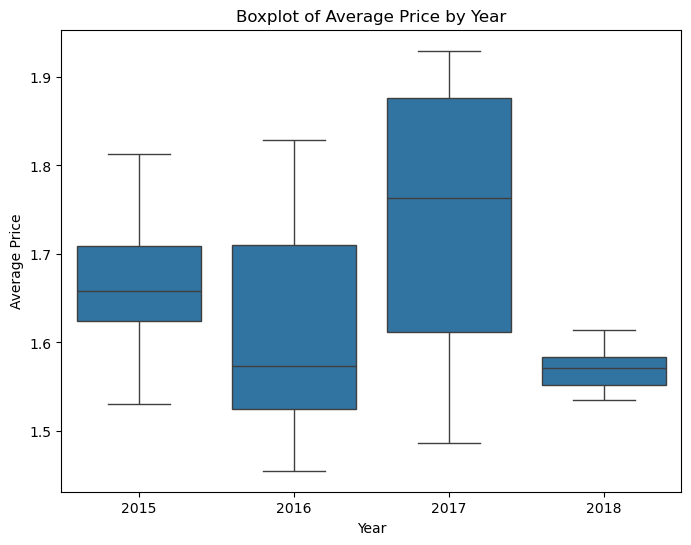

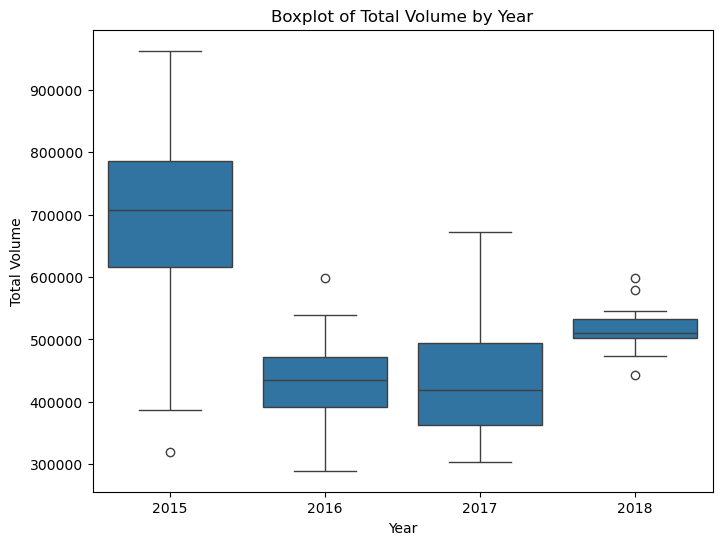

In [71]:
# Boxplots

# Boxplot of Average Price by Year
plt.figure(figsize=(8, 6))
sns.boxplot(x=avocado_weekly_data['Date'].dt.year, y=avocado_weekly_data['AveragePrice'])
plt.title("Boxplot of Average Price by Year")
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.show()

# Boxplot  of Total Volume by Year
plt.figure(figsize=(8, 6))
sns.boxplot(x=avocado_weekly_data['Date'].dt.year, y=avocado_weekly_data['Total Volume'])
plt.title("Boxplot of Total Volume by Year",)
plt.xlabel("Year")
plt.ylabel("Total Volume")
plt.show()


Observation:

The boxplots show that the average price of avocados was highest in 2017. The total volume of avocados sold was highest in 2015 and dropped in the following years which indicates changing consumer behavior and market trends over time.

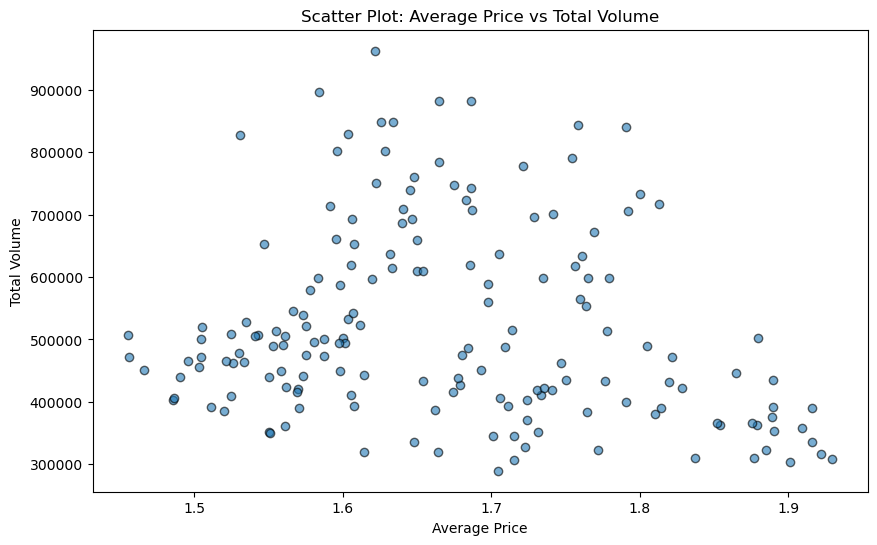

In [72]:
# Scatter plot to analyze Average Price and Total Volume

plt.figure(figsize=(10, 6))
plt.scatter(avocado_weekly_data['AveragePrice'], avocado_weekly_data['Total Volume'], alpha=0.6, edgecolor='k')
plt.title("Scatter Plot: Average Price vs Total Volume")
plt.xlabel("Average Price")
plt.ylabel("Total Volume")
plt.show()


Observation:

The scatter plot shows that as the average price of avocados increases the total volume sold tends to decrease. This suggests that people may buy fewer avocados when prices are higher.

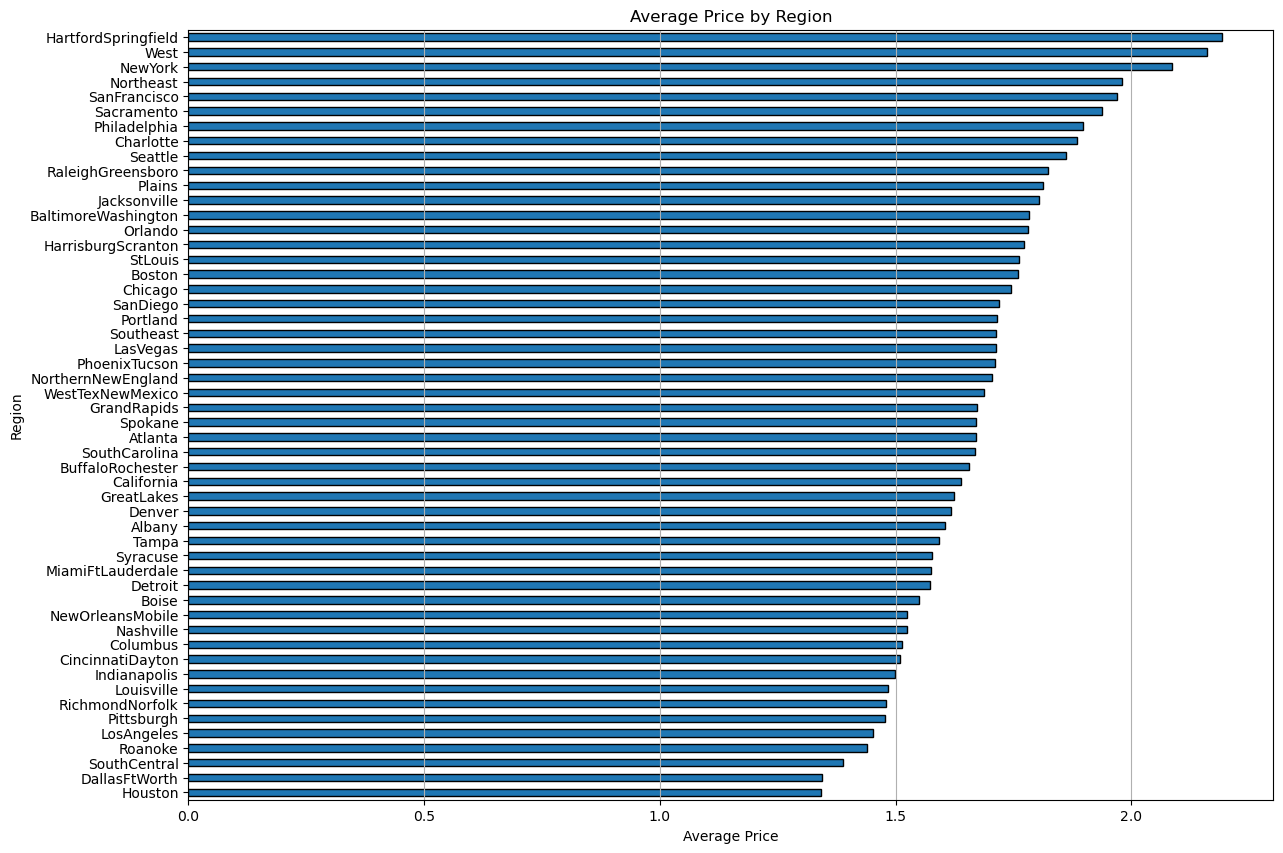

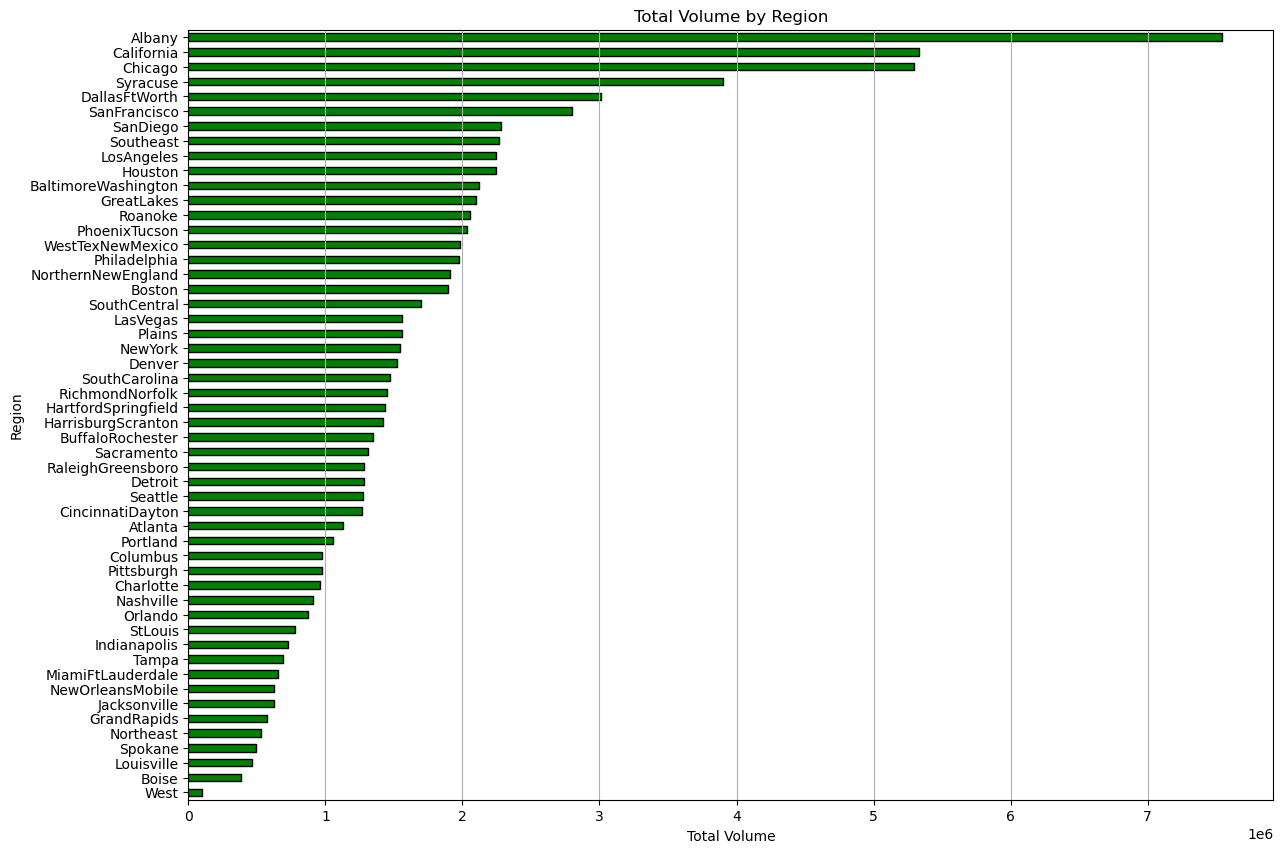

In [73]:
# Bar Graphs

# Average Price across regions
plt.figure(figsize=(14, 10))
regional_avg_price = avocado_data_cleaned_1.groupby('region')['AveragePrice'].mean().sort_values()
regional_avg_price.plot(kind='barh', edgecolor='black')
plt.title("Average Price by Region")
plt.xlabel("Average Price")
plt.ylabel("Region")
plt.grid(axis='x')
plt.show()

# Total Volume across regions
plt.figure(figsize=(14, 10))
regional_total_volume = avocado_data_cleaned_1.groupby('region')['Total Volume'].sum().sort_values()
regional_total_volume.plot(kind='barh', color='green', edgecolor='black')
plt.title("Total Volume by Region")
plt.xlabel("Total Volume")
plt.ylabel("Region")
plt.grid(axis='x')
plt.show()


Observation:

The average price of avocados varies across regions. Hartford/Springfield having the highest prices and Houston the lowest. The total volume sold is highest in regions like Albany and California. It shows regional differences in demand and pricing.

--- STATIONARITY CHECK ---

In [74]:
# ADF Test

def adf_test(series, title):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Test for {title}:")
    print(f"Test Statistic: {result[0]:.4f}")
    print(f"P-Value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    print("Stationary" if result[1] <= 0.05 else "Not Stationary")
    print()

adf_test(avocado_weekly_data['Total Volume'], "Total Volume")
adf_test(avocado_weekly_data['AveragePrice'], "Average Price")



ADF Test for Total Volume:
Test Statistic: -2.1074
P-Value: 0.2416
Critical Values:
  1%: -3.4711
  5%: -2.8794
  10%: -2.5763
Not Stationary

ADF Test for Average Price:
Test Statistic: -2.8312
P-Value: 0.0540
Critical Values:
  1%: -3.4699
  5%: -2.8789
  10%: -2.5760
Not Stationary



Observation: 

The ADF test on the main columns Average price and Total Volume shows that both the columns are non-stationary. We need to apply technique to make the data stationary which is an important step for model implementation.

In [75]:
# Log Transformation to get Stationarity in data

# Applying log transformation
avocado_weekly_data['Log_Total_Volume'] = avocado_weekly_data['Total Volume'].apply(lambda x: np.log(x + 1))
avocado_weekly_data['Log_Average_Price'] = avocado_weekly_data['AveragePrice'].apply(lambda x: np.log(x + 1))

# Applying differencing
avocado_weekly_data['Diff_Log_Total_Volume'] = avocado_weekly_data['Log_Total_Volume'].diff().dropna()
avocado_weekly_data['Diff_Log_Average_Price'] = avocado_weekly_data['Log_Average_Price'].diff().dropna()

# Stationarity check after transformations
adf_test(avocado_weekly_data['Diff_Log_Total_Volume'].dropna(), "Differenced Log(Total Volume)")
adf_test(avocado_weekly_data['Diff_Log_Average_Price'].dropna(), "Differenced Log(Average Price)")


ADF Test for Differenced Log(Total Volume):
Test Statistic: -11.2166
P-Value: 0.0000
Critical Values:
  1%: -3.4706
  5%: -2.8792
  10%: -2.5762
Stationary

ADF Test for Differenced Log(Average Price):
Test Statistic: -11.6439
P-Value: 0.0000
Critical Values:
  1%: -3.4704
  5%: -2.8791
  10%: -2.5761
Stationary



Observation: 

After applying the log tranformation and differencing the data is stationary. This allows us to proceed further with forecasting models.

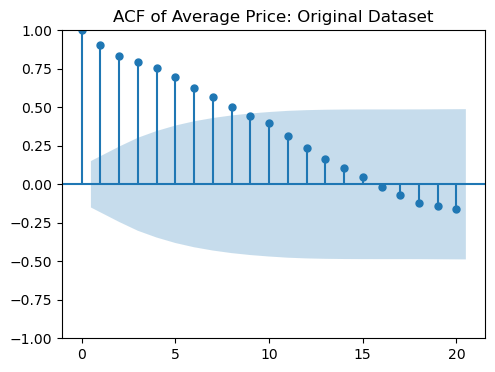

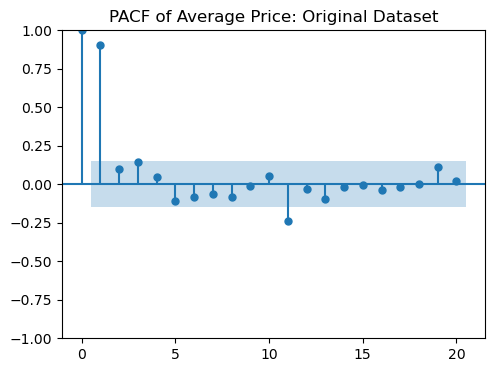

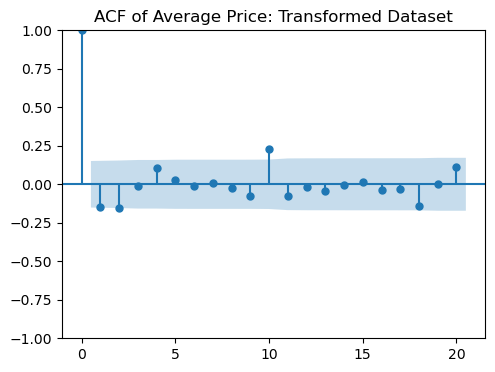

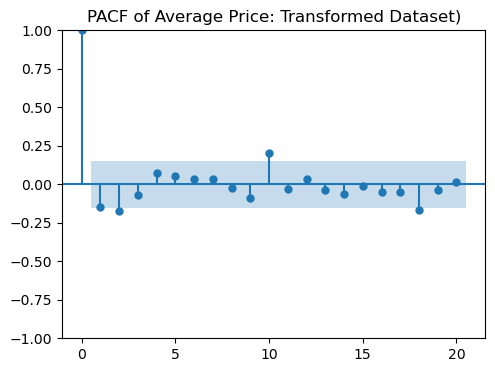

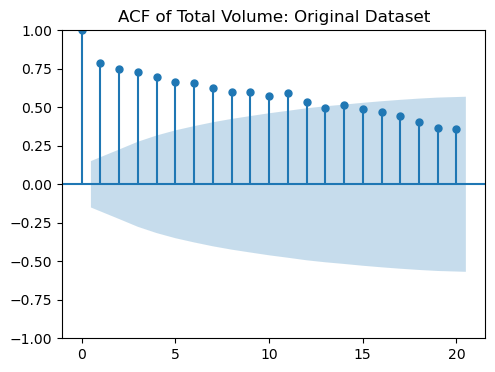

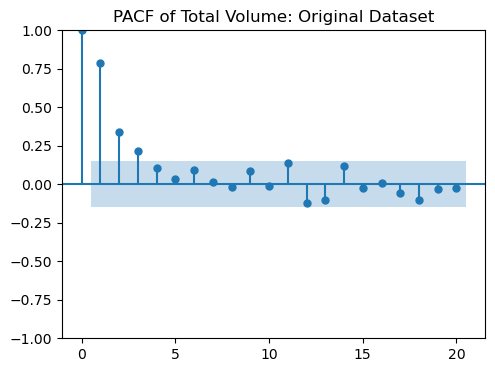

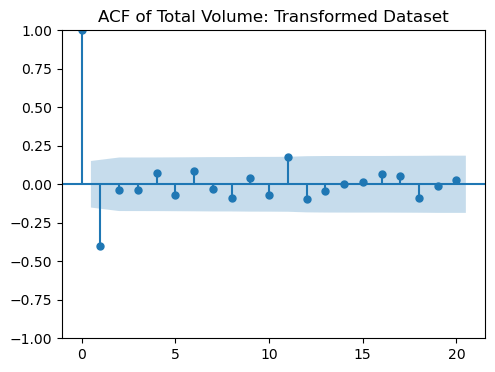

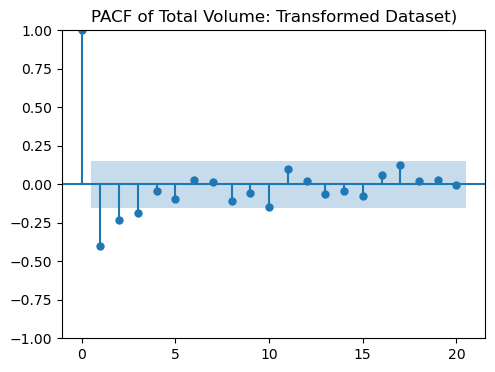

In [76]:
# ACF and PACF Plots 

# Average Price

# Original dataset - Average Price
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(avocado_weekly_data['AveragePrice'].dropna(), lags=20, ax=plt.gca(), title='ACF of Average Price: Original Dataset')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plot_pacf(avocado_weekly_data['AveragePrice'].dropna(), lags=20, ax=plt.gca(), title='PACF of Average Price: Original Dataset')
plt.show()

# Transformed dataset - Average Price
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(avocado_weekly_data['Diff_Log_Average_Price'].dropna(), lags=20, ax=plt.gca(), title='ACF of Average Price: Transformed Dataset')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plot_pacf(avocado_weekly_data['Diff_Log_Average_Price'].dropna(), lags=20, ax=plt.gca(), title='PACF of Average Price: Transformed Dataset)')
plt.show()

# Total Volume

# Original dataset - Total Volume
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(avocado_weekly_data['Total Volume'].dropna(), lags=20, ax=plt.gca(), title='ACF of Total Volume: Original Dataset')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plot_pacf(avocado_weekly_data['Total Volume'].dropna(), lags=20, ax=plt.gca(), title='PACF of Total Volume: Original Dataset')
plt.show()

# Transformed dataset - Total Volume
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(avocado_weekly_data['Diff_Log_Total_Volume'].dropna(), lags=20, ax=plt.gca(), title='ACF of Total Volume: Transformed Dataset')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plot_pacf(avocado_weekly_data['Diff_Log_Total_Volume'].dropna(), lags=20, ax=plt.gca(), title='PACF of Total Volume: Transformed Dataset)')
plt.show()


Observations: 
1. Original Dataset - Average Price:
ACF: The autocorrelation drops gradually this indicates a non-stationary series.
PACF: There is a strong correlation at lag 1 and some significant lags. This is suggesting an autoregressive component.
2. Transformed Dataset - Average Price:
ACF: After differencing, the ACF shows a sharp cutoff. This confirms that the series is now stationary.
PACF: Significant lag at 1 indicates an AR(1).

3. Original Dataset - Total Volume:
ACF: The autocorrelation drops gradually this indicates a non-stationary series.
PACF: There is a strong correlation at 1 and smaller correlations at higher lags. This is suggesting an autoregressive component.
4. Transformed Dataset - Total Volume:
ACF: After differencing, the ACF shows a sharp cutoff. This confirms that the series is now stationary.
PACF: Significant lags at 1 and 2 suggests an AR(2).

--- MODEL IMPLEMENTATION ---

In [77]:
# ARIMA Model 

avocado_weekly_data['Date'] = pd.to_datetime(avocado_weekly_data['Date'])
avocado_weekly_data.set_index('Date', inplace=True)
avocado_weekly_data.index.freq = 'W'

# Training and testing data
split_point = int(0.8 * len(avocado_weekly_data))

train_data_avg_price = avocado_weekly_data['Log_Average_Price'][:split_point].dropna()
test_data_avg_price = avocado_weekly_data['Log_Average_Price'][split_point:].dropna()

train_data_total_volume = avocado_weekly_data['Log_Total_Volume'][:split_point].dropna()
test_data_total_volume = avocado_weekly_data['Log_Total_Volume'][split_point:].dropna()

# Fit ARIMA model on training data
arima_model_avg_price = ARIMA(train_data_avg_price, order=(1, 1, 1)).fit()
arima_model_total_volume = ARIMA(train_data_total_volume, order=(2, 1, 1)).fit()

avg_price_predictions = arima_model_avg_price.predict(start=test_data_avg_price.index[0], end=test_data_avg_price.index[-1])
total_volume_predictions = arima_model_total_volume.predict(start=test_data_total_volume.index[0], end=test_data_total_volume.index[-1])

def calculate_r_squared(actual, predicted):
    ss_total = np.sum((actual - np.mean(actual)) ** 2)
    ss_residual = np.sum((actual - predicted) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

# Evaluate model for Average Price
mae_avg_price = mean_absolute_error(test_data_avg_price, avg_price_predictions)
rmse_avg_price = np.sqrt(mean_squared_error(test_data_avg_price, avg_price_predictions))
mape_avg_price = np.mean(np.abs((test_data_avg_price - avg_price_predictions) / test_data_avg_price)) * 100
r_squared_avg_price = calculate_r_squared(test_data_avg_price, avg_price_predictions)

# Evaluate model for Total Volume
mae_total_volume = mean_absolute_error(test_data_total_volume, total_volume_predictions)
rmse_total_volume = np.sqrt(mean_squared_error(test_data_total_volume, total_volume_predictions))
mape_total_volume = np.mean(np.abs((test_data_total_volume - total_volume_predictions) / test_data_total_volume)) * 100
r_squared_total_volume = calculate_r_squared(test_data_total_volume, total_volume_predictions)

evaluation_metrics = {
    "Average Price": {
        "MAE": mae_avg_price, 
        "RMSE": rmse_avg_price, 
        "MAPE": mape_avg_price, 
        "R-squared": r_squared_avg_price},
    "Total Volume": {
        "MAE": mae_total_volume, 
        "RMSE": rmse_total_volume, 
        "MAPE": mape_total_volume, 
        "R-squared": r_squared_total_volume}}

evaluation_metrics

c:\Users\moham\anaconda3\envs\nci12\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Average Price': {'MAE': 0.04795999069762687,
  'RMSE': 0.053319427313651205,
  'MAPE': 4.916787614702261,
  'R-squared': -0.17170642486950127},
 'Total Volume': {'MAE': 0.11105662216369219,
  'RMSE': 0.14495024460409908,
  'MAPE': 0.8446650080617266,
  'R-squared': 0.27516361159434743}}

Observations: 

The ARIMA model performed well in terms of prediction accuracy with MAPE being small 4.9% for Average Price and 0.84% for Total Volume. But the model has negative R-squared values which means it could not explain the overall variability in the data . This suggests that the ARIMA model might not completely capture important patterns like seasonality or complex trends in the data.

In [78]:
# SARIMA Model

# Fit SARIMA model
sarima_model_avg_price = SARIMAX(train_data_avg_price, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
sarima_model_total_volume = SARIMAX(train_data_total_volume, order=(2, 1, 1), seasonal_order=(1, 1, 1, 52), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

sarima_avg_price_predictions = sarima_model_avg_price.predict(start=test_data_avg_price.index[0], end=test_data_avg_price.index[-1])
sarima_total_volume_predictions = sarima_model_total_volume.predict(start=test_data_total_volume.index[0], end=test_data_total_volume.index[-1])

# Evaluating model for average price
mae_sarima_avg_price = mean_absolute_error(test_data_avg_price, sarima_avg_price_predictions)
rmse_sarima_avg_price = np.sqrt(mean_squared_error(test_data_avg_price, sarima_avg_price_predictions))
mape_sarima_avg_price = np.mean(np.abs((test_data_avg_price - sarima_avg_price_predictions) / test_data_avg_price)) * 100
r_squared_sarima_avg_price = calculate_r_squared(test_data_avg_price, sarima_avg_price_predictions)

# Evaluating model for Total Volume
mae_sarima_total_volume = mean_absolute_error(test_data_total_volume, sarima_total_volume_predictions)
rmse_sarima_total_volume = np.sqrt(mean_squared_error(test_data_total_volume, sarima_total_volume_predictions))
mape_sarima_total_volume = np.mean(np.abs((test_data_total_volume - sarima_total_volume_predictions) / test_data_total_volume)) * 100
r_squared_sarima_total_volume = calculate_r_squared(test_data_total_volume, sarima_total_volume_predictions)

sarima_evaluation_metrics = {
    "Average Price": {
        "MAE": mae_sarima_avg_price,
        "RMSE": rmse_sarima_avg_price,
        "MAPE": mape_sarima_avg_price,
        "R-squared": r_squared_sarima_avg_price},
    "Total Volume": {
        "MAE": mae_sarima_total_volume,
        "RMSE": rmse_sarima_total_volume,
        "MAPE": mape_sarima_total_volume,
        "R-squared": r_squared_sarima_total_volume}}

sarima_evaluation_metrics


c:\Users\moham\anaconda3\envs\nci12\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\moham\anaconda3\envs\nci12\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\moham\anaconda3\envs\nci12\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


{'Average Price': {'MAE': 0.02889939809588875,
  'RMSE': 0.03590269396111485,
  'MAPE': 2.8350639394345776,
  'R-squared': 0.4687463422492886},
 'Total Volume': {'MAE': 0.15714409085530737,
  'RMSE': 0.1866135108358813,
  'MAPE': 1.2023767163924985,
  'R-squared': -0.20140172078889673}}

Observations: 

The SARIMA models performed slightly worse than ARIMA in predicting Average Price and Total Volume. The errors - MAE, RMSE, MAPE are higher and the R-squared values for Total Volume are negative. This means that the model couldn't properly explain the data's variability. For Average Price, SARIMA performs better than ARIMA by lower values of MAE, RMSE, MAPE and positive R-squared. This suggests that SARIMA might be more suitable for Average Price but not Total Volume in the dataset.

In [79]:
# ETS Model

# Fit ETS model
ets_model_avg_price = ExponentialSmoothing(train_data_avg_price, trend='additive', seasonal='additive', seasonal_periods=52).fit()
ets_model_total_volume = ExponentialSmoothing(train_data_total_volume, trend='additive', seasonal='additive', seasonal_periods=52).fit()

# Predictions for evaluation
ets_avg_price_predictions = ets_model_avg_price.forecast(len(test_data_avg_price))
ets_total_volume_predictions = ets_model_total_volume.forecast(len(test_data_total_volume))

# Evaluating ETS model for Average Price
mae_ets_avg_price = mean_absolute_error(test_data_avg_price, ets_avg_price_predictions)
rmse_ets_avg_price = np.sqrt(mean_squared_error(test_data_avg_price, ets_avg_price_predictions))
mape_ets_avg_price = np.mean(np.abs((test_data_avg_price - ets_avg_price_predictions) / test_data_avg_price)) * 100
r_squared_ets_avg_price = calculate_r_squared(test_data_avg_price, ets_avg_price_predictions)

# Evaluating ETS model for Total Volume
mae_ets_total_volume = mean_absolute_error(test_data_total_volume, ets_total_volume_predictions)
rmse_ets_total_volume = np.sqrt(mean_squared_error(test_data_total_volume, ets_total_volume_predictions))
mape_ets_total_volume = np.mean(np.abs((test_data_total_volume - ets_total_volume_predictions) / test_data_total_volume)) * 100
r_squared_ets_total_volume = calculate_r_squared(test_data_total_volume, ets_total_volume_predictions)

ets_evaluation_metrics = {
    "Average Price": {
        "MAE": mae_ets_avg_price,
        "RMSE": rmse_ets_avg_price,
        "MAPE": mape_ets_avg_price,
        "R-squared": r_squared_ets_avg_price},
    "Total Volume": {
        "MAE": mae_ets_total_volume,
        "RMSE": rmse_ets_total_volume,
        "MAPE": mape_ets_total_volume,
        "R-squared": r_squared_ets_total_volume}}

ets_evaluation_metrics


{'Average Price': {'MAE': 0.021247681469624694,
  'RMSE': 0.027570441592194656,
  'MAPE': 2.0800403496678754,
  'R-squared': 0.6867181004639142},
 'Total Volume': {'MAE': 0.32946120089333597,
  'RMSE': 0.3702268198489419,
  'MAPE': 2.50192760665401,
  'R-squared': -3.728657248347532}}

Observation: 

The ETS models performed very well than ARIMA and SARIMA. The model made reasonably accurate predictions with MAPE being 2.1% for Average Price and below 3% for Total Volume. The R-squared value for Average Price was 68.6% indicates that the model explained a fair portion of the data's variability while the R-squared value for Total Volume was negative, suggesting the model struggled to explain its variability. These results suggest that while ETS is effective for forecasting Average Price but it may not be the best choice for Total Volume in this dataset.

In [80]:
# Comparison of Models

# Average Price comparison
comparison_table_avg_price = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'ETS'],
    'MAE': [mae_avg_price, mae_sarima_avg_price, mae_ets_avg_price],
    'RMSE': [rmse_avg_price, rmse_sarima_avg_price, rmse_ets_avg_price],
    'MAPE': [mape_avg_price, mape_sarima_avg_price, mape_ets_avg_price],
    'R-Squared': [r_squared_avg_price, r_squared_sarima_avg_price, r_squared_ets_avg_price]
})

# Total Volume comparison
comparison_table_total_volume = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'ETS'],
    'MAE': [mae_total_volume, mae_sarima_total_volume, mae_ets_total_volume],
    'RMSE': [rmse_total_volume, rmse_sarima_total_volume, rmse_ets_total_volume],
    'MAPE': [mape_total_volume, mape_sarima_total_volume, mape_ets_total_volume],
    'R-Squared': [r_squared_total_volume, r_squared_sarima_total_volume, r_squared_ets_total_volume]
})

print("Model Performance Comparison: Average Price")
print(comparison_table_avg_price)
print("\nModel Performance Comparison: Total Volume")
print(comparison_table_total_volume)



Model Performance Comparison: Average Price
    Model       MAE      RMSE      MAPE  R-Squared
0   ARIMA  0.047960  0.053319  4.916788  -0.171706
1  SARIMA  0.028899  0.035903  2.835064   0.468746
2     ETS  0.021248  0.027570  2.080040   0.686718

Model Performance Comparison: Total Volume
    Model       MAE      RMSE      MAPE  R-Squared
0   ARIMA  0.111057  0.144950  0.844665   0.275164
1  SARIMA  0.157144  0.186614  1.202377  -0.201402
2     ETS  0.329461  0.370227  2.501928  -3.728657


Observation: 

When predicting the average price of avocados the ETS model performs the best with the lowest errors (MAE, RMSE, and MAPE) and the highest R-squared value, indicating a good fit. SARIMA also performs decently but ARIMA struggles with higher errors and a negative R-squared value showing poor predictive power.

For total volume ARIMA performs better than SARIMA and ETS achieving lower errors and a positive R-squared value though the fit isn't very strong. SARIMA and ETS models show higher errors and poor R-squared values with ETS being the least effective. This suggests that different models excel in predicting different aspects of avocado data.

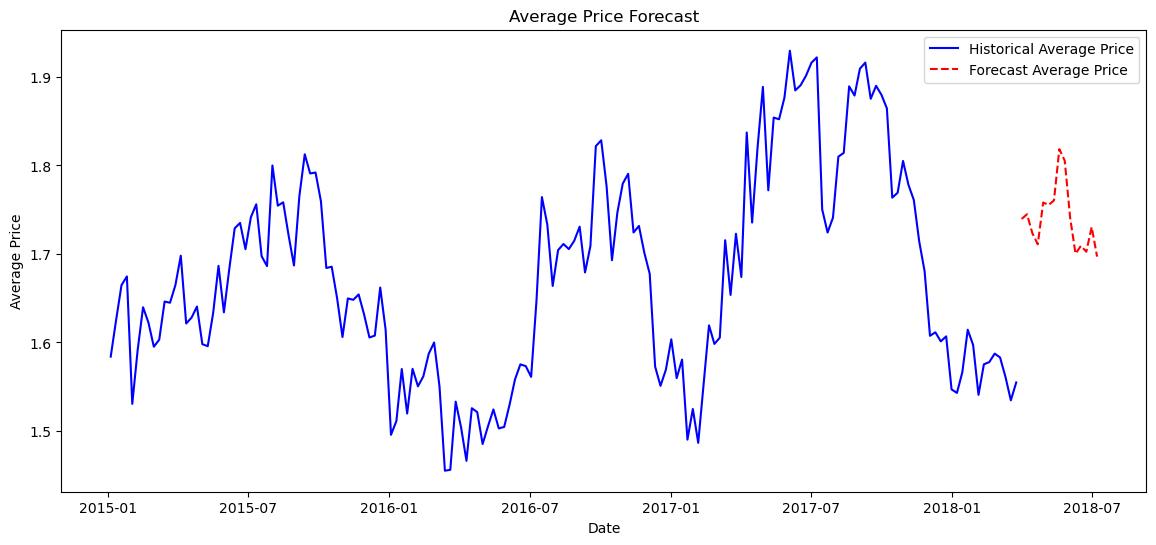

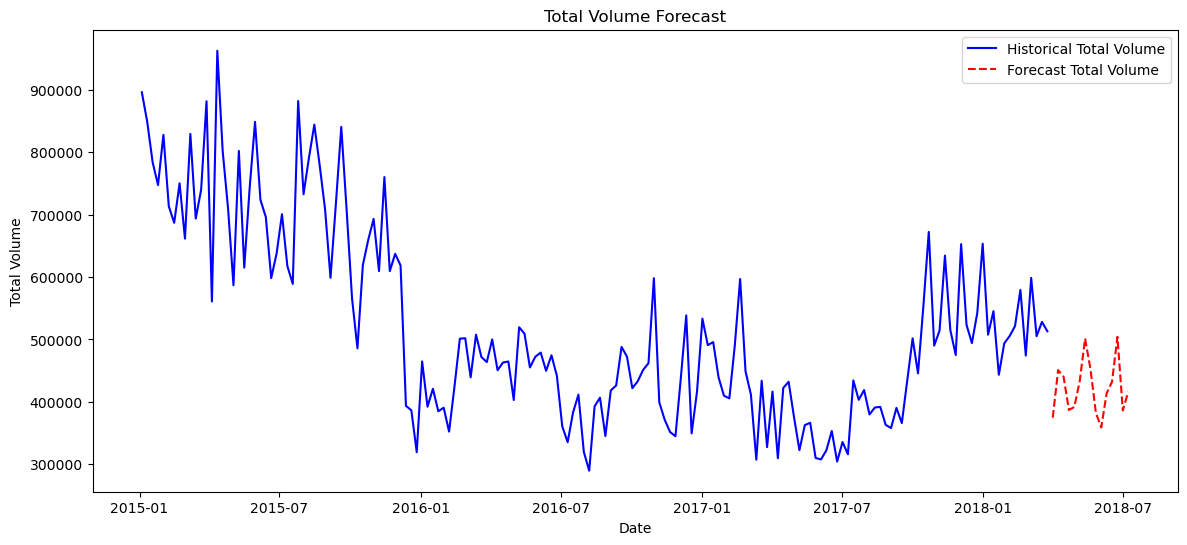

In [81]:
# Forecast Graph

# Forecast future values
forecast_avg_price = np.expm1(ets_model_avg_price.forecast(steps=15))
forecast_total_volume = np.expm1(ets_model_total_volume.forecast(steps=15))
forecast_dates = pd.date_range(start=avocado_weekly_data.index[-1] + pd.Timedelta(days=7), periods=15, freq='W')

# Plot for Average Price forecast
plt.figure(figsize=(14, 6))
plt.plot(avocado_weekly_data.index, np.expm1(avocado_weekly_data['Log_Average_Price']), label="Historical Average Price", color='blue')
plt.plot(forecast_dates, forecast_avg_price, label="Forecast Average Price", color='red', linestyle='--')
plt.title("Average Price Forecast")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.legend()
plt.show()

# Plot for Total Volume forecast
plt.figure(figsize=(14, 6))
plt.plot(avocado_weekly_data.index, np.expm1(avocado_weekly_data['Log_Total_Volume']), label="Historical Total Volume", color='blue')
plt.plot(forecast_dates, forecast_total_volume, label="Forecast Total Volume", color='red', linestyle='--')
plt.title("Total Volume Forecast")
plt.xlabel("Date")
plt.ylabel("Total Volume")
plt.legend()
plt.show()


Observation: 

The forecast shows that the Average Price of avocados is expected to remain fairly stable with a slight increase over the next 15 weeks, this indicates about the consistent pricing trends. The Total Volume of sales is projected to grow steadily suggesting increasing demand. These patterns highlight the seasonal nature of avocado sales and provide a reliable prediction for future trends. Businesses can use these insights to prepare for upcoming demand and maintain optimal stock levels while ensuring competitive pricing.

Conclusion:

In conclusion, this project has successfully analyzed avocado sales data using time series models such as ARIMA, SARIMA and ETS. The analysis provided meaningful insights into average prices and total sales volumes showing seasonal variations and regional differences. Among these models, ETS was the best model in predicting average prices while ARIMA was more effective for forecasting total volume though both showed limitations in certain aspects. These findings can assist businesses in making informed decisions about pricing, inventory and demand planning.

For future work, considering external factors such as weather patterns, regional preferences and economic changes could enhance forecast accuracy. Also, forecasting with advanced machine learning models might solve complex patterns and improve predictions of avocado sales.